In [1]:
import sys
import os
import numpy as np
import json

from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
import keras.backend.tensorflow_backend as K
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Model
from keras.models import Sequential, InputLayer
from keras.layers import Dense, Embedding, Activation, LSTM, Bidirectional
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
import keras.regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import np_utils
from keras.datasets import reuters
from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
tf.set_random_seed(0)
max_features = 15000
#text_max_words = 200

## 데이터 로드

In [3]:
DATA_IN_PATH = './data/word_dict/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

input_data = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
label_data = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [4]:
TEST_SPLIT = 0.1
RNG_SEED = 13371447
VOCAB_SIZE = prepro_configs['vocab_size']+1
EMB_SIZE = 128
BATCH_SIZE = 32

train_input, eval_input, train_label, eval_label = train_test_split(input_data,
                                                                    label_data,
                                                                    test_size=TEST_SPLIT,
                                                                    random_state=RNG_SEED)

## 모델 설정

In [5]:
def Model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Dropout(0.5))
    model.add(Conv1D(256, 3, padding='valid', kernel_initializer='he_normal', activation='relu', strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [6]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1920000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')

In [8]:
with K.tf_ops.device('/device:GPU:0'):
    hist = model.fit(train_input, train_label, batch_size = BATCH_SIZE,
                     epochs = 50, validation_split = 0.2, callbacks=[early_stopping])


Train on 108000 samples, validate on 27000 samples
Epoch 1/50
108000/108000 [==============================] - 22s 203us/step - loss: 0.4428 - accuracy: 0.7888 - val_loss: 0.3946 - val_accuracy: 0.8182
Epoch 2/50
108000/108000 [==============================] - 20s 184us/step - loss: 0.3600 - accuracy: 0.8400 - val_loss: 0.3925 - val_accuracy: 0.8213
Epoch 3/50
108000/108000 [==============================] - 20s 184us/step - loss: 0.3154 - accuracy: 0.8643 - val_loss: 0.4005 - val_accuracy: 0.8235


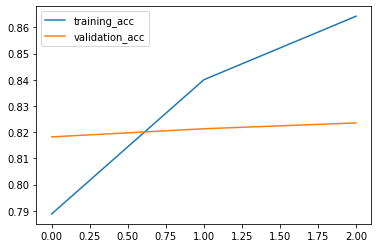

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training_acc', 'validation_acc'], loc = 'upper left')
plt.show()

In [10]:
results = model.evaluate(eval_input, eval_label)
print('Test accuracy: ', results[1])

15000/15000 [==============================] - 1s 57us/step
Test accuracy:  0.8198666572570801


## 모델 사용 

In [11]:
#model.predict_classes(train_input[:8])

In [12]:
#hist.history

## K-fold validation 사용 

In [13]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in kf.split(input_data):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = label_data[train_index], label_data[test_index]

In [14]:
model = Model()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1920000   
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 256)         98560     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min')

In [16]:
with K.tf_ops.device('/device:GPU:0'):
        hist = model.fit(X_train, y_train, batch_size = BATCH_SIZE,
                     epochs = 10)

Epoch 1/10
120000/120000 [==============================] - 21s 174us/step - loss: 0.5210 - accuracy: 0.7437
Epoch 2/10
120000/120000 [==============================] - 20s 171us/step - loss: 0.5525 - accuracy: 0.7234
Epoch 3/10
120000/120000 [==============================] - 21s 171us/step - loss: 0.5535 - accuracy: 0.7174
Epoch 4/10
120000/120000 [==============================] - 21s 171us/step - loss: 0.5431 - accuracy: 0.7309
Epoch 5/10
120000/120000 [==============================] - 20s 171us/step - loss: 0.5435 - accuracy: 0.7322
Epoch 6/10
120000/120000 [==============================] - 20s 171us/step - loss: 0.5385 - accuracy: 0.7380
Epoch 7/10
120000/120000 [==============================] - 21s 171us/step - loss: 0.5565 - accuracy: 0.7208
Epoch 8/10
120000/120000 [==============================] - 21s 172us/step - loss: 0.5477 - accuracy: 0.7307
Epoch 9/10
120000/120000 [==============================] - 20s 170us/step - loss: 0.5569 - accuracy: 0.7184
Epoch 10/10
120000/

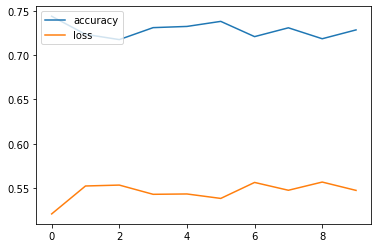

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['loss'])
plt.legend(['accuracy', 'loss'], loc = 'upper left')
plt.show()

In [18]:
score = model.evaluate(X_test,y_test)
print('Test accuracy: ', score[1])

30000/30000 [==============================] - 2s 69us/step
Test accuracy:  0.7717333436012268
